# Amazon E-Commerce Analysis - BlissBaby

Data analysis for Amazon product performance, returns, and advertising metrics.

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

returns_df = pd.read_csv('outputs/cleaned/returns.csv')
orders_df = pd.read_csv('outputs/cleaned/orders.csv')
sponsored_df = pd.read_csv('outputs/cleaned/sponsored_products.csv')
sku_metrics_df = pd.read_csv('outputs/cleaned/sku_metrics.csv')

print(f"Data loaded: {len(orders_df):,} orders, {len(returns_df):,} returns")

Data loaded: 1,573 orders, 34 returns


## Question 1: When are products most returned?

In [10]:
returns_df['return_date'] = pd.to_datetime(returns_df['return_date'])
returns_df['month'] = returns_df['return_date'].dt.month_name()
returns_df['day_of_week'] = returns_df['return_date'].dt.day_name()
returns_df['week'] = returns_df['return_date'].dt.isocalendar().week

returns_by_month = returns_df.groupby('month')['quantity'].sum().sort_values(ascending=False)
returns_by_day = returns_df.groupby('day_of_week')['quantity'].sum().sort_values(ascending=False)

print("Returns by Month:")
print(returns_by_month)
print("\nReturns by Day of Week:")
print(returns_by_day)
print(f"\nPeak return period: {returns_by_month.idxmax()} on {returns_by_day.idxmax()}s")
print(f"Total: {returns_by_month.max()} returns")

Returns by Month:
month
November    28
October      6
Name: quantity, dtype: int64

Returns by Day of Week:
day_of_week
Friday       7
Saturday     6
Thursday     5
Tuesday      5
Monday       4
Wednesday    4
Sunday       3
Name: quantity, dtype: int64

Peak return period: November on Fridays
Total: 28 returns


## Question 2: Product with most ads and clicks

In [11]:
ad_performance = sponsored_df.groupby('advertised_sku').agg({
    'impressions': 'sum',
    'clicks': 'sum',
    'spend': 'sum',
    'ad_sales': 'sum',
    'orders': 'sum',
    'units': 'sum'
}).round(2)

ad_performance['ROAS'] = (ad_performance['ad_sales'] / ad_performance['spend']).round(2)
ad_performance = ad_performance.sort_values('clicks', ascending=False)

print("Ad Performance by Product:")
print(ad_performance)

top_ad_product = ad_performance.index[0]
top_stats = ad_performance.iloc[0]

print(f"\nMost advertised: {top_ad_product}")
print(f"Impressions: {top_stats['impressions']:,.0f}")
print(f"Clicks: {top_stats['clicks']:,.0f}")
print(f"Ad Spend: ${top_stats['spend']:,.2f}")
print(f"ROAS: ${top_stats['ROAS']:.2f} per $1")

Ad Performance by Product:
                impressions  clicks   spend  ad_sales  orders  units  ROAS
advertised_sku                                                            
UB0101               532365    2328  645.01   4716.48     296    298  7.31
USP103               218084     865  945.66   2748.00     170    188  2.91
USP102               167833     826  548.64   2558.75     139    146  4.66
UDC101               218508     441  574.45   1199.66      70     82  2.09
UBW101               173525     390  441.86    758.26      43     46  1.72
USP101                52898     219  348.96    656.62      31     38  1.88
UBL101                76668     172  212.28    376.78      22     22  1.77

Most advertised: UB0101
Impressions: 532,365
Clicks: 2,328
Ad Spend: $645.01
ROAS: $7.31 per $1


## Question 3: Is it also the best selling product? Why?

In [12]:
sales_performance = sku_metrics_df[sku_metrics_df['sku'] != 'UNKNOWN'].copy()
sales_performance = sales_performance.groupby('sku').agg({
    'orders_cnt': 'sum',
    'units_sold': 'sum',
    'gross_sales': 'sum',
    'net_profit': 'sum',
    'ad_spend_sp': 'sum'
}).sort_values('units_sold', ascending=False)

print("Sales by Product:")
print(sales_performance)

best_seller = sales_performance.index[0]
print(f"\nBest selling: {best_seller}")
print(f"Units: {sales_performance.iloc[0]['units_sold']:,.0f}")
print(f"Revenue: ${sales_performance.iloc[0]['gross_sales']:,.2f}")

if top_ad_product == best_seller:
    print(f"\nYES - {top_ad_product} is both most advertised AND best seller")
    
    total_sales = sales_performance.loc[best_seller, 'gross_sales']
    ad_sales = ad_performance.loc[top_ad_product, 'ad_sales']
    organic_pct = ((total_sales - ad_sales) / total_sales * 100)
    
    print(f"\nWhy it works:")
    print(f"- High ad spend (${ad_performance.loc[top_ad_product, 'spend']:,.2f})")
    print(f"- Good ROAS: ${ad_performance.loc[top_ad_product, 'ROAS']:.2f}")
    print(f"- {organic_pct:.1f}% organic sales")
else:
    print(f"\nNO - {top_ad_product} (most ads) vs {best_seller} (best sales)")
    print(f"Likely better organic reach or product-market fit")

Sales by Product:
        orders_cnt  units_sold  gross_sales   net_profit  ad_spend_sp
sku                                                                  
UB0101         505         524      9253.65 -1202.461871      645.010
UDC101         309         376      7803.28   480.522151      574.445
USP102         250         264      5193.04  -185.168994      548.640
USP103         218         244      4408.81  -598.302675      945.660
UBW101         137         154      3134.23  -193.351212      441.860
UBL101         111         116      2078.96  -294.147546      212.280
USP101          42          46      1167.34   -67.828332      348.960

Best selling: UB0101
Units: 524
Revenue: $9,253.65

YES - UB0101 is both most advertised AND best seller

Why it works:
- High ad spend ($645.01)
- Good ROAS: $7.31
- 49.0% organic sales


## Question 4: Least performing products

In [13]:
least_clicks = ad_performance.sort_values('clicks', ascending=True).head(3)
least_sales = sales_performance.sort_values('gross_sales', ascending=True).head(3)
least_efficient = ad_performance.sort_values('ROAS', ascending=True).head(3)

print("Least performing products:\n")

print("Lowest clicks:")
print(least_clicks[['clicks', 'spend', 'ROAS']])

print("\nLowest sales:")
print(least_sales[['units_sold', 'gross_sales']])

print("\nWorst ROAS:")
print(least_efficient[['clicks', 'spend', 'ROAS']])

returns_by_sku = returns_df.groupby('sku')['quantity'].sum()
return_rates = (returns_by_sku / sales_performance['units_sold'] * 100).round(2).sort_values(ascending=False)

print("\nHighest return rates:")
print(return_rates.head(3))

Least performing products:

Lowest clicks:
                clicks   spend  ROAS
advertised_sku                      
UBL101             172  212.28  1.77
USP101             219  348.96  1.88
UBW101             390  441.86  1.72

Lowest sales:
        units_sold  gross_sales
sku                            
USP101          46      1167.34
UBL101         116      2078.96
UBW101         154      3134.23

Worst ROAS:
                clicks   spend  ROAS
advertised_sku                      
UBW101             390  441.86  1.72
UBL101             172  212.28  1.77
USP101             219  348.96  1.88

Highest return rates:
sku
USP101    6.52
UBW101    3.25
UBL101    2.59
dtype: float64


## Visualization 1: Ad Performance vs Sales

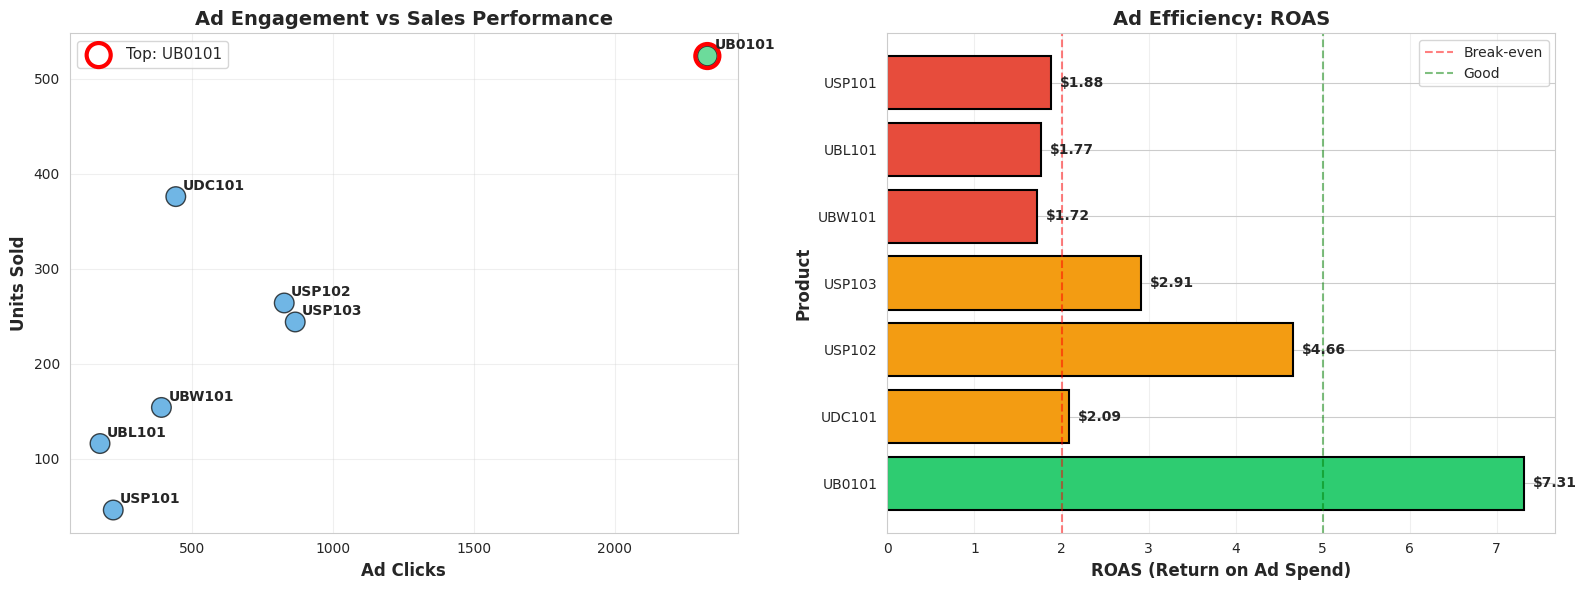

In [14]:
comparison = sales_performance.merge(
    ad_performance[['clicks', 'spend', 'ROAS']], 
    left_index=True, 
    right_index=True
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

colors = ['#2ecc71' if idx == top_ad_product else '#3498db' for idx in comparison.index]
ax1.scatter(comparison['clicks'], comparison['units_sold'], s=200, c=colors, alpha=0.7, edgecolors='black')
ax1.set_xlabel('Ad Clicks', fontsize=12, fontweight='bold')
ax1.set_ylabel('Units Sold', fontsize=12, fontweight='bold')
ax1.set_title('Ad Engagement vs Sales Performance', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)

for idx, row in comparison.iterrows():
    ax1.annotate(idx, (row['clicks'], row['units_sold']), 
                xytext=(5, 5), textcoords='offset points', fontsize=10, fontweight='bold')

ax1.scatter(comparison.loc[top_ad_product, 'clicks'], 
           comparison.loc[top_ad_product, 'units_sold'], 
           s=300, c='none', edgecolors='red', linewidths=3, label=f'Top: {top_ad_product}')
ax1.legend(fontsize=11)

colors2 = ['#e74c3c' if row['ROAS'] < 2 else '#f39c12' if row['ROAS'] < 5 else '#2ecc71' 
          for idx, row in comparison.iterrows()]
ax2.barh(comparison.index, comparison['ROAS'], color=colors2, edgecolor='black', linewidth=1.5)
ax2.set_xlabel('ROAS (Return on Ad Spend)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Product', fontsize=12, fontweight='bold')
ax2.set_title('Ad Efficiency: ROAS', fontsize=14, fontweight='bold')
ax2.axvline(x=2, color='red', linestyle='--', alpha=0.5, label='Break-even')
ax2.axvline(x=5, color='green', linestyle='--', alpha=0.5, label='Good')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='x')

for i, (idx, val) in enumerate(comparison['ROAS'].items()):
    ax2.text(val + 0.1, i, f'${val:.2f}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Visualization 2: Return Patterns

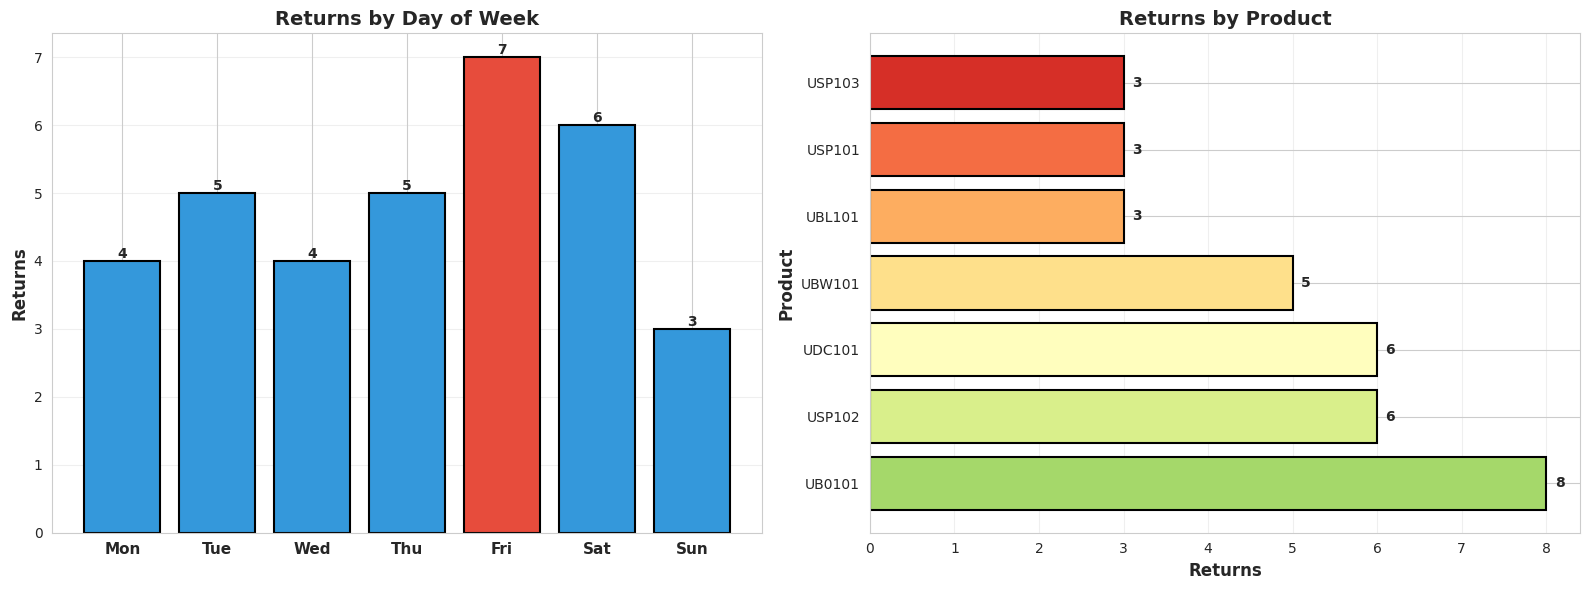

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_data = returns_df['day_of_week'].value_counts().reindex(day_order, fill_value=0)
colors_dow = ['#e74c3c' if day == returns_by_day.idxmax() else '#3498db' for day in dow_data.index]

bars1 = ax1.bar(range(len(dow_data)), dow_data.values, color=colors_dow, edgecolor='black', linewidth=1.5)
ax1.set_xticks(range(len(dow_data)))
ax1.set_xticklabels([day[:3] for day in dow_data.index], fontsize=11, fontweight='bold')
ax1.set_ylabel('Returns', fontsize=12, fontweight='bold')
ax1.set_title('Returns by Day of Week', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontweight='bold', fontsize=10)

returns_by_product = returns_df.groupby('sku')['quantity'].sum().sort_values(ascending=False)
colors_prod = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(returns_by_product)))

ax2.barh(returns_by_product.index, returns_by_product.values, color=colors_prod, 
                 edgecolor='black', linewidth=1.5)
ax2.set_xlabel('Returns', fontsize=12, fontweight='bold')
ax2.set_ylabel('Product', fontsize=12, fontweight='bold')
ax2.set_title('Returns by Product', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='x')

for i, (idx, val) in enumerate(returns_by_product.items()):
    ax2.text(val + 0.1, i, f'{int(val)}', va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

## Summary

In [16]:
print("Key Findings:")
print("="*60)

print(f"\n1. Returns")
print(f"   Peak: {returns_by_month.idxmax()} on {returns_by_day.idxmax()}s")
print(f"   Total: {returns_df['quantity'].sum()} returns")

print(f"\n2. Most Advertised Product: {top_ad_product}")
print(f"   Clicks: {ad_performance.loc[top_ad_product, 'clicks']:,.0f}")
print(f"   ROAS: ${ad_performance.loc[top_ad_product, 'ROAS']:.2f}")
print(f"   Best seller: {'Yes' if top_ad_product == best_seller else 'No'}")

print(f"\n3. Best Selling Product: {best_seller}")
print(f"   Units: {sales_performance.loc[best_seller, 'units_sold']:,.0f}")
print(f"   Revenue: ${sales_performance.loc[best_seller, 'gross_sales']:,.2f}")

if top_ad_product == best_seller:
    total_sales = sales_performance.loc[best_seller, 'gross_sales']
    ad_sales = ad_performance.loc[top_ad_product, 'ad_sales']
    organic_pct = ((total_sales - ad_sales) / total_sales * 100)
    print(f"   Mix: {organic_pct:.0f}% organic, {100-organic_pct:.0f}% ads")

print(f"\n4. Weakest Performers")
print(f"   Least clicks: {least_clicks.index[0]} ({least_clicks.iloc[0]['clicks']:.0f})")
print(f"   Worst ROAS: {least_efficient.index[0]} (${least_efficient.iloc[0]['ROAS']:.2f})")

print("\n" + "="*60)

Key Findings:

1. Returns
   Peak: November on Fridays
   Total: 34 returns

2. Most Advertised Product: UB0101
   Clicks: 2,328
   ROAS: $7.31
   Best seller: Yes

3. Best Selling Product: UB0101
   Units: 524
   Revenue: $9,253.65
   Mix: 49% organic, 51% ads

4. Weakest Performers
   Least clicks: UBL101 (172)
   Worst ROAS: UBW101 ($1.72)

